Use `astroquery` to get some tables of white dwarfs, plus SPAMS manually-assembled catalog.

In [33]:
from astroplan import Observer, FixedTarget
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

catalog_name = 'J/MNRAS/446/4078/'

catalog_list = Vizier.find_catalogs(catalog_name)
catalogs = Vizier.get_catalogs(list(catalog_list.keys()))
Vizier.ROW_LIMIT = -1       # Otherwise would only show first 50 values
catalog_table = catalogs[0] # This is the table with the data

RAs = catalog_table['_RAJ2000']
Decs = catalog_table['_DEJ2000']
sc = SkyCoord(ra=RAs, dec=Decs, frame='icrs')
names = catalog_table['SDSS']
types = catalog_table['Type']
gmag = catalog_table['gmag']

[Kepler et al. 2015](http://vizier.u-strasbg.fr.offcampus.lib.washington.edu/viz-bin/VizieR?-source=J%2FMNRAS%2F446%2F4078): WDs in SDSS DR 10

In [40]:
max_g = 17.5
bright_metal_polluted = np.array(['z' in str(t).lower() and g < max_g
                                  for t, g in zip(types.data, 
                                                  gmag.data)])

target_list = [FixedTarget(c, name="SDSS{0:s}_{1:.2f}".format(n.decode('ascii'), g)) 
               for c, n, g, b in zip(sc, names, gmag, bright_metal_polluted) if b]

print('{0} stars selected'.format(len(target_list)))

44 stars selected


In [48]:
obs = Observer.at_site("APO", timezone='US/Mountain')

from astroplan import (is_observable, observability_table, 
                       AltitudeConstraint, AtNightConstraint)
from astropy.time import Time

constraints = [AltitudeConstraint(min=30*u.deg), 
               AtNightConstraint.twilight_astronomical()]

# Figure out when "tonight" is
# present_time = Time.now()
# if not obs.is_night(present_time):
#     # If it's currently day time at runtime, find time of sunset and sunrise
#     tonight_start = obs.twilight_evening_astronomical(present_time, which='next')
#     tonight_end = obs.twilight_morning_astronomical(present_time, which='next')
# else:
#     # Otherwise find time to next sunrise
#     tonight_start = present_time
#     tonight_end = obs.twilight_morning_astronomical(present_time, which='next')

days_range = Time('2016-01-15 19:00') + np.arange(0, 365-30, 30)*u.day
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
observable_targets = []
# months = months[:3]
# days_range = days_range[:3]

for month, day in zip(months, days_range):
    tonight_start = obs.twilight_evening_astronomical(day, which='next')
    tonight_end = obs.twilight_morning_astronomical(day, which='next')
    table = observability_table(constraints, obs, target_list, 
                                time_range=Time([tonight_start, tonight_end]))
    seventypercent = table['fraction of time observable'] > 0.75
    seventypercent_targets = table['target name'][seventypercent].data
    print("{0}\n----------\n{1}\n".format(day.datetime.date(), 
                                          '\n'.join(sorted(seventypercent_targets, 
                                                           key=lambda a: a[-4:]))))
    observable_targets.append(seventypercent_targets)

2016-01-15
----------
SDSS083006.17+475150.29_15.81
SDSS081531.20+245222.62_16.09
SDSS075610.70+670424.96_16.38
SDSS074323.44+420800.71_17.12
SDSS080127.11+141454.88_17.47

2016-02-14
----------
SDSS083006.17+475150.29_15.81
SDSS081531.20+245222.62_16.09
SDSS115358.81+353928.84_16.27
SDSS075610.70+670424.96_16.38
SDSS074323.44+420800.71_17.12
SDSS091615.48+132833.13_17.31

2016-03-15
----------
SDSS115358.81+353928.84_16.27

2016-04-14
----------
SDSS151913.31+261720.62_15.76
SDSS142741.03+014254.94_15.93
SDSS143458.49+085425.74_16.12
SDSS115358.81+353928.84_16.27
SDSS145506.86+094203.96_16.62
SDSS150032.31-011404.85_16.67
SDSS143350.80+071452.22_16.80
SDSS153000.98+211218.18_16.92
SDSS135627.84+264110.79_17.00
SDSS160741.26+254220.38_17.00
SDSS150011.76+064211.48_17.02
SDSS151646.27+092631.70_17.02
SDSS162345.29+465041.57_17.11
SDSS135836.89+184922.84_17.25
SDSS145648.83-005613.42_17.34
SDSS162310.50+425831.15_17.44

2016-05-14
----------
SDSS164201.51+361726.16_14.72
SDSS151913.31+26

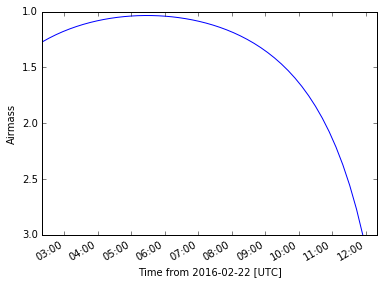

In [59]:
%matplotlib inline
from astroplan.plots import plot_airmass

target = 'SDSS083006.17+475150.29_15.81'

def sdss_name_to_target(name):
    ra = name[4:13]
    dec = name[13:-6]
    ra = "{0}h{1}m{2}s".format(ra[:2], ra[2:4], ra[4:])
    dec = "{0}d{1}m{2}s".format(dec[:3], dec[3:5], dec[5])
    return FixedTarget(SkyCoord(ra=ra, dec=dec), name=name)

present_time = Time.now()
if not obs.is_night(present_time):
    # If it's currently day time at runtime, find time of sunset and sunrise
    tonight_start = obs.twilight_evening_astronomical(present_time, which='next')
    tonight_end = obs.twilight_morning_astronomical(present_time, which='next')
else:
    # Otherwise find time to next sunrise
    tonight_start = present_time
    tonight_end = obs.twilight_morning_astronomical(present_time, which='next')
    
times = Time(np.linspace(tonight_start.jd, tonight_end.jd, 50), format='jd')
plot_airmass(sdss_name_to_target(target), obs, times);